# Unbiased Split of Event Logs

In this tutorial we provide an overview of how the unbiased split of event
logs [1] works and how to use it in the `skpm` package.

## The *biased* split problem

In machine learning, standardizing how datasets are split is a common, often
essential, practice to ensure fair and reproducible results. However, in the
field of Process Mining, machine learning applications have not consistently
adopted this practice. Weytjens and De Weerdt's work [1] proposes the first
significant effort to address this gap.

More specifically, their paper tackles three key challenges:

1. **Inconsistent Dataset Split**: Different datasets and preprocessing
methods make it hard to compare research outcomes. Certain preprocessing
choices can even lead to biased results due to the use of domain knowledge
that may not be accessible to all researchers.
2. **Data Leakage**: Training and test sets often overlap, with events from
the same case appearing in both, which leads to overfitted performance
measures and inaccurate predictions.
3. **Test Set Bias**: The test sets frequently suffer from bias due to
unequal distributions of case durations and active cases, especially at the
start and end of the dataset. This skews evaluation results, making them
less reflective of real-world performance.
The `SkPM` package adapted the available code from the authors' GitHub [2].

## Unbised Split API

Only a few datasets are currently supported by the unbiased split method.
The usage is really simple and can be seen in the following example:

In [33]:
from skpm.event_logs import split, BPI20RequestForPayment

bpi20 = BPI20RequestForPayment()

train, test = split.unbiased(bpi20, **bpi20.unbiased_split_params)
train.shape, test.shape

((23295, 14), (7053, 14))

The hyperparameters for the unbiased split are hardcoded in the original
implementation. However, they are
derived based on an data-driven analysis. In the future, we may consider
to implement this generic approach in order to extend the unbiased split
to other datasets. The hardcoded hyperparameters are:
- `start_date`: the start date of the event log.
- `end_date`: the end date of the event log.
- `max_days`: the maximum duration of cases.

In [15]:
bpi20.unbiased_split_params

{'start_date': None, 'end_date': '2018-12', 'max_days': 28.86}

For datasets without hardcoded hyperparameters, an exception will be raised:

In [16]:
from skpm.event_logs import Sepsis

sepsis = Sepsis()
try:
    _ = split.unbiased(sepsis, **sepsis.unbiased_split_params)
except Exception as e:
    print(e)

Unbiased split not available for Sepsis


The unbiased split is available for the following datasets:
- :class:`~skpm.event_logs.BPI12`
- :class:`~skpm.event_logs.BPI17`
- :class:`~skpm.event_logs.BPI19`
- :class:`~skpm.event_logs.BPI20PrepaidTravelCosts`
- :class:`~skpm.event_logs.BPI20TravelPermitData`
- :class:`~skpm.event_logs.BPI20RequestForPayment`

We now visualize the remaining time target over time. There is no overlap between the training and test sets, ensuring that cases from the training set do not bias the test set.

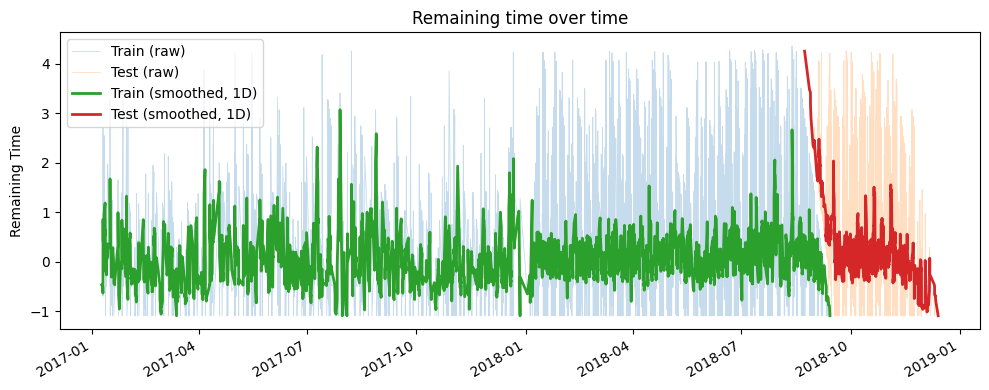

In [34]:
import matplotlib.pyplot as plt
from skpm.feature_extraction import TimestampExtractor
from sklearn.preprocessing import StandardScaler

def plot_as_series(train, test):
    # some preprocessing
    time_unit = "d"
    ts = TimestampExtractor(
        case_features=["accumulated_time", "remaining_time"],
        event_features="all",
        time_unit=time_unit,
    )

    train[ts.get_feature_names_out()] = ts.fit_transform(train)
    test[ts.get_feature_names_out()] = ts.transform(test)


    scaler = StandardScaler()
    train.loc[:, ["remaining_time"]] = scaler.fit_transform(train[["remaining_time"]])
    test.loc[:, ["remaining_time"]] = scaler.transform(test[["remaining_time"]])

    # set rolling window for smoothing
    rolling_window = "1D"

    # converting it into a time series
    series_train = train.set_index("time:timestamp").sort_index()["remaining_time"]
    series_test = test.set_index("time:timestamp").sort_index()["remaining_time"]

    fig, ax = plt.subplots(figsize=(10, 4))

    # plot raw data (semi-transparent)
    series_train.plot(ax=ax, alpha=0.25, linewidth=0.6, label="Train (raw)")
    series_test.plot(ax=ax, alpha=0.25, linewidth=0.6, label="Test (raw)")

    # smoothed data using rolling mean
    series_train.rolling(rolling_window).mean().plot(
        ax=ax, linewidth=2, label=f"Train (smoothed, {rolling_window})"
    )
    series_test.rolling(rolling_window).mean().plot(
        ax=ax, linewidth=2, label=f"Test (smoothed, {rolling_window})"
    )

    ax.set_ylabel("Remaining Time")
    ax.set_xlabel("")
    ax.set_title("Remaining time over time")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_as_series(train, test)

Alternatively, the traditional temporal split does not guarantee that cases from the training set won't overlap with those in the test set, as shown in the figure below. In this example, some cases start before the beginning of the test period and finish after it ends.

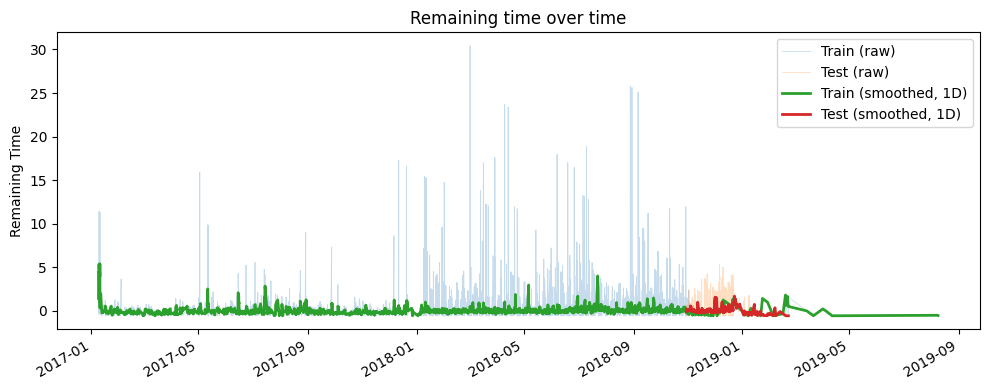

In [50]:
train, test = split.temporal(bpi20.dataframe, test_len=0.3)
plot_as_series(train, test)

## References

- [1] Hans Weytjens, Jochen De Weerdt. Creating Unbiased Public Benchmark
Datasets with Data Leakage Prevention for Predictive Process Monitoring, 2021. doi: 10.1007/978-3-030-94343-1_2
- [2] https://github.com/hansweytjens/predictive-process-monitoring-benchmarks